## Содержание


### Подключение библиотек и скриптов

In [764]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler

from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures


In [765]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

### Пути к директориям и файлам

In [766]:
TRAIN_DATASET_PATH = '/home/gans/Документы/Обучение/GeekBrains/9. Библиотеки Python для DS/1. course project/input data/train.csv'
TEST_DATASET_PATH = '/home/gans/Документы/Обучение/GeekBrains/9. Библиотеки Python для DS/1. course project/input data/test.csv'

### Описание датасета
**Id** - идентификационный номер квартиры

**DistrictId** - идентификационный номер района

**Rooms** - количество комнат

**Square** - площадь

**LifeSquare** - жилая площадь

**KitchenSquare** - площадь кухни

**Floor** - этаж

**HouseFloor** - количество этажей в доме

**HouseYear** - год постройки дома

**Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности

**Social_1**, **Social_2**, **Social_3** - социальные показатели местности

**Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья

**Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров

**Price** - цена квартиры


### 1. Загрузка данных

In [767]:

df_train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
df_test = pd.read_csv(TEST_DATASET_PATH, index_col='Id')

df_train.shape, df_test.shape

((10000, 19), (5000, 18))

In [768]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [769]:
df_test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,NaN,0,0,B
15856,74,2.00,69.26,NaN,1.00,6,1.00,1977,0.08,B,B,6,1437,3,NaN,0,2,B
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,"4,702.00",5,5,B
15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,NaN,3,3,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,NaN,0,0,A


### Приведение типов

In [770]:
df_train.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [771]:
# Оставил про запас
#df_train['DistrictId'] = df_train['DistrictId'].astype(str)

### 2. Получение информации о данных df_train (EDA)

In [772]:
print(f'df_train:\n {df_train.columns}')

df_train:
 Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price'],
      dtype='object')


Развернутая информация

In [773]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

Можно отметить, что:
- есть пропуски в LifeSquare
- есть пропуски в Healthcare_1
- большая часть полей типа float64, но так же есть поля типа int64 и object

Статистика по всем количественным столбцам

In [774]:
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,50.40,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,43.59,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,20.00,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,36.00,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,75.00,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,209.00,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


Статистика по всем категориальным столбцам

In [775]:
df_train.describe(include='object')

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


In [776]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [777]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [778]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Заменим текстовые значения признаков Ecology_2, Ecology_3 и Shops_2 бинарными значениями.

In [779]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

df_train[feature_bin_names] = df_train[feature_bin_names].replace({'A' :0, 'B' :1})

Оценим взаимосвязь признаков

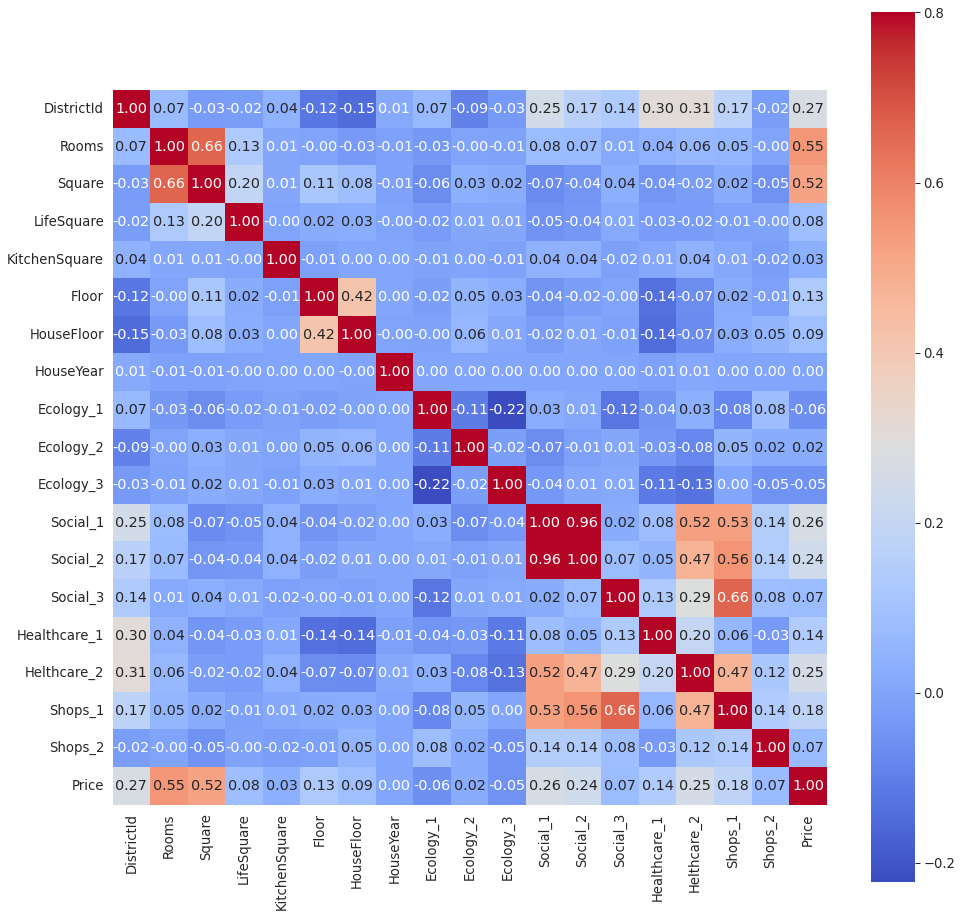

In [780]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corrmat, vmax=.8, annot=True, fmt='.2f', cmap='coolwarm', square=True);

Можно заметить, что целевая переменная Price не сильно коррелирует с признаками, за исключением, наверное, Rooms и Square.

### 3. Очистка данных и устранение пропусковии

Оценим распределение параметров

array([[<AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>],
       [<AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>],
       [<AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Ecology_2'}>,
        <AxesSubplot:title={'center':'Ecology_3'}>,
        <AxesSubplot:title={'center':'Social_1'}>],
       [<AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>],
       [<AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Shops_2'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],


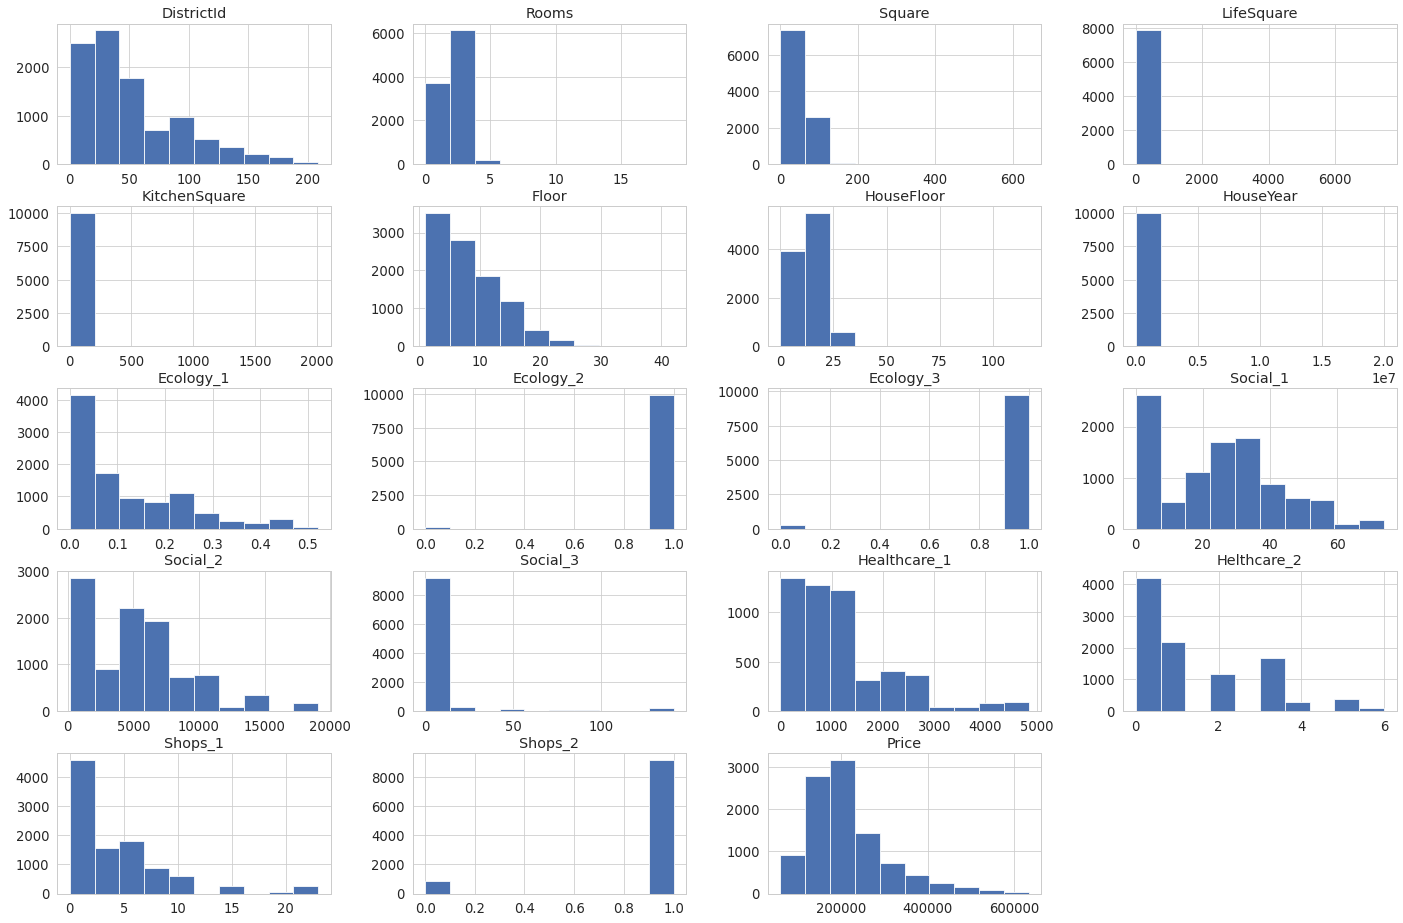

In [781]:
df_train.hist(figsize=(24,16))

Можно предположить о наличии выбросов в следующих признаках:
- Room
- Square
- LifeSquare
- KitchenSquare
- Floor
- HouseFloor
- HouseYear
- Ecology_2
- Ecology_3
- Social_3
- Shops_2

#### Целевая переменная

<Figure size 720x360 with 0 Axes>

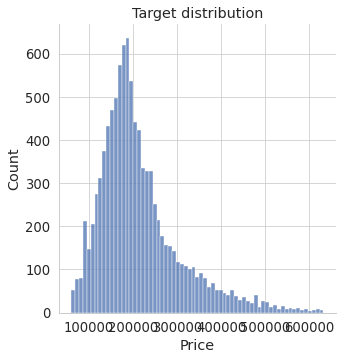

In [782]:
plt.figure(figsize = (10, 5))

sns.displot(df_train['Price'])
plt.title('Target distribution');

Определение количества пропусков в датасете

In [783]:
total = df_train.isnull().sum().sort_values(ascending=False)
percentage = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Persent'])
missing_data.head()

,Total,Persent
Healthcare_1,4798,47.98
LifeSquare,2113,21.13
DistrictId,0,0.00
Ecology_3,0,0.00
Shops_2,0,0.00


Вывод: Имеем два признака с пропусками: LifeSquare - 21,13% и Healthcare_1 - 47,98%.
Произведем работу над ними.

#### Square
Т.к. признак LifeSquare достаточно сильно зависит от Rooms и Square, поработаем с ними.

In [784]:
df_train[['Rooms', 'Square', 'LifeSquare']].describe()

,Rooms,Square,LifeSquare
count,"10,000.00","10,000.00","7,887.00"
mean,1.89,56.32,37.20
std,0.84,21.06,86.24
min,0.00,1.14,0.37
25%,1.00,41.77,22.77
50%,2.00,52.51,32.78
75%,2.00,65.90,45.13
max,19.00,641.07,"7,480.59"


<AxesSubplot:>

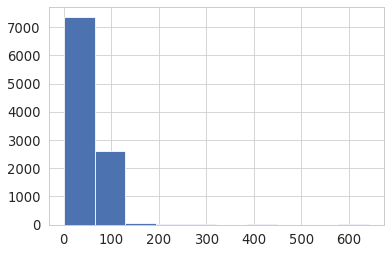

In [785]:
df_train.Square.hist()

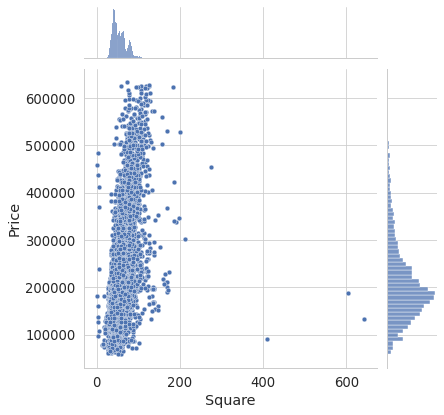

In [786]:
sns.jointplot(df_train['Square'], df_train['Price'], kind='scatter', height=6);

In [787]:
df_train.sort_values(by='Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14786,1,1.00,1.14,4.53,1.00,3,1.00,1977,0.01,1,1,1,264,0,NaN,0,1,1,"181,434.83"
15744,34,1.00,1.99,2.64,1.00,21,4.00,1977,0.07,1,1,53,13670,4,NaN,1,11,1,"458,378.78"
3224,27,0.00,2.38,0.87,0.00,1,0.00,1977,0.02,1,1,2,469,0,NaN,0,0,1,"126,596.94"
10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,1,1,5,1564,0,540.00,0,0,1,"137,597.60"
6782,45,1.00,2.95,5.26,1.00,3,1.00,1977,0.20,1,1,23,5212,6,NaN,3,2,1,"438,005.18"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7917,27,0.00,212.93,211.23,0.00,2,3.00,2008,0.21,1,1,9,1892,0,NaN,0,1,1,"302,211.26"
5548,86,5.00,275.65,233.95,26.00,12,37.00,2011,0.16,1,0,31,7010,5,"4,508.00",3,7,1,"455,264.88"
2307,102,1.00,409.43,410.64,10.00,4,4.00,2016,0.24,1,1,26,3889,6,705.00,3,6,1,"90,470.43"


In [788]:
df_train[df_train.Square <= 10]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.00,5.50,67.63,1.00,24,22.00,1977,0.13,1,1,43,8429,3,NaN,3,9,1,"412,511.09"
11526,27,1.00,4.63,1.97,1.00,18,1.00,1977,0.01,1,1,4,915,0,NaN,0,0,1,"107,604.27"
10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,1,1,5,1564,0,540.00,0,0,1,"137,597.60"
10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,1,1,9,1892,0,NaN,0,1,1,"97,560.72"
9487,5,1.00,5.13,5.55,1.00,1,1.00,1977,0.15,1,1,16,3433,4,"2,643.00",4,5,1,"369,472.40"
3224,27,0.00,2.38,0.87,0.00,1,0.00,1977,0.02,1,1,2,469,0,NaN,0,0,1,"126,596.94"
4504,27,3.00,4.39,5.61,1.00,8,19.00,2016,0.21,1,1,9,1892,0,NaN,0,1,1,"161,379.07"
14786,1,1.00,1.14,4.53,1.00,3,1.00,1977,0.01,1,1,1,264,0,NaN,0,1,1,"181,434.83"
13265,1,3.00,4.82,79.77,0.00,6,17.00,1977,0.01,1,1,1,264,0,NaN,0,1,1,"237,716.68"


In [789]:
df_train.loc[df_train['Square'] < 10, 'Square'] *= 10
df_train.loc[df_train['Square'] > 300, 'Square'] /= 10

<AxesSubplot:>

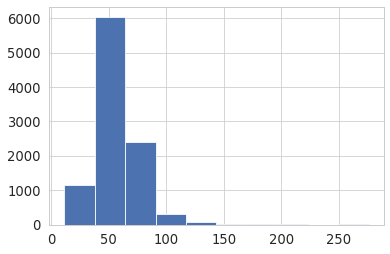

In [790]:
df_train.Square.hist()

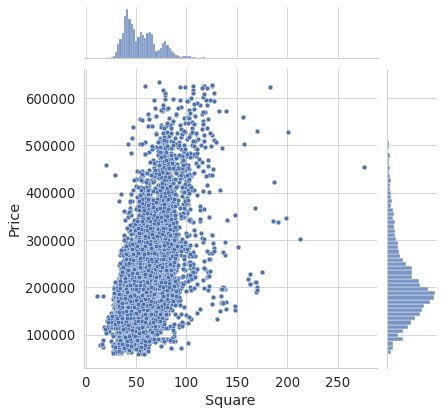

In [791]:
sns.jointplot(df_train['Square'], df_train['Price'], kind='scatter', height=6);

In [792]:
df_train.sort_values(by='Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14786,1,1.00,11.37,4.53,1.00,3,1.00,1977,0.01,1,1,1,264,0,NaN,0,1,1,"181,434.83"
12676,81,3.00,13.78,15.99,7.00,4,5.00,1960,0.32,1,1,25,4756,16,"2,857.00",5,8,1,"78,388.81"
6927,21,1.00,16.12,8.82,0.00,2,5.00,1965,0.19,1,1,47,8004,3,125.00,3,5,1,"79,913.27"
15877,57,3.00,16.55,16.70,8.00,5,5.00,1962,0.13,1,1,49,11395,3,"1,406.00",3,4,0,"77,835.19"
15127,150,1.00,17.05,20.04,8.00,7,12.00,1982,0.30,1,1,52,10311,6,NaN,1,9,1,"74,222.11"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3718,56,3.00,190.86,107.38,19.00,7,3.00,2007,0.00,1,1,23,5067,4,NaN,2,6,1,"338,644.08"
4249,23,5.00,198.93,123.14,10.00,1,2.00,2011,0.01,1,1,2,475,0,NaN,0,0,1,"345,665.21"
16568,27,4.00,200.33,201.63,25.00,1,2.00,2013,0.04,1,1,53,14892,4,NaN,1,4,1,"528,560.51"


In [793]:
len(df_train[(df_train['Square'] < df_train['LifeSquare'] + df_train['KitchenSquare'])])

837

Т.е. в 837 случаях общая площадь квартиры меньше жилой + кухни. Варианты: не трогать, поменять местами, заменить на сумму жилой + кухни.
Пока оставлю

#### Rooms

In [794]:
df_train.sort_values(by='Rooms')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
770,28,0.00,49.48,NaN,0.00,16,0.00,2015,0.12,1,1,30,6207,1,"1,183.00",1,0,1,"217,009.34"
3224,27,0.00,23.77,0.87,0.00,1,0.00,1977,0.02,1,1,2,469,0,NaN,0,0,1,"126,596.94"
9443,27,0.00,87.76,85.13,0.00,5,15.00,1977,0.21,1,1,9,1892,0,NaN,0,1,1,"219,281.92"
7917,27,0.00,212.93,211.23,0.00,2,3.00,2008,0.21,1,1,9,1892,0,NaN,0,1,1,"302,211.26"
3159,88,0.00,38.70,19.35,9.00,9,16.00,1982,0.13,1,1,43,8429,3,NaN,3,9,1,"158,998.11"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,78,5.00,118.87,69.02,10.00,15,16.00,1998,0.09,1,1,21,4346,2,165.00,1,2,1,"496,026.67"
14003,99,6.00,59.41,38.70,6.00,7,9.00,1969,0.03,1,1,66,10573,1,"1,322.00",3,8,1,"229,661.96"
14865,9,10.00,60.87,38.42,10.00,3,2.00,1994,0.16,1,1,25,5648,1,30.00,2,4,1,"172,329.27"


<AxesSubplot:>

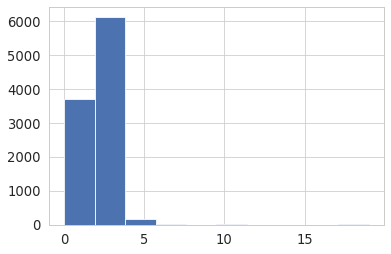

In [795]:
df_train.Rooms.hist()

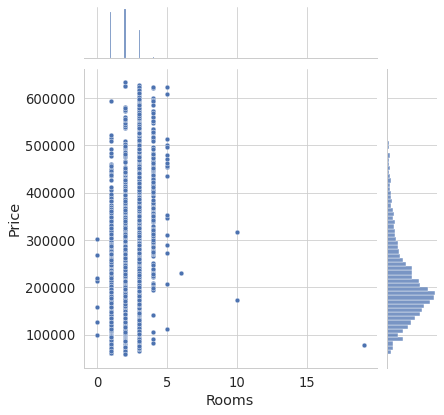

In [796]:
sns.jointplot(df_train['Rooms'], df_train['Price'], kind='scatter', height=6)

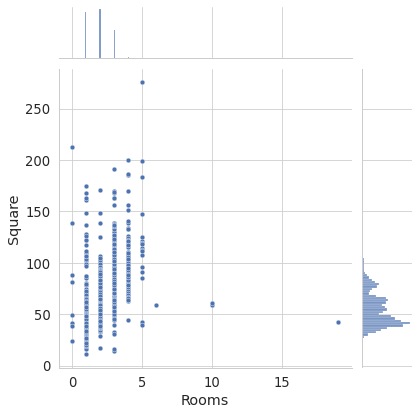

In [797]:
sns.jointplot(df_train['Rooms'], df_train['Square'], kind='scatter', height=6)

Явные выбросы на значениях больше 5. На данном этапе просито их исключим, не проводя паралели с Price

In [798]:
df_train.loc[((df_train['Rooms'] == 0) | (df_train['Rooms'] > 5)) & (df_train['Square'] < 38), 'Rooms'] = 1
df_train.loc[((df_train['Rooms'] == 0) | (df_train['Rooms'] > 5)) & ((df_train['Square'] >= 38) & (df_train['Square'] < 100)), 'Rooms'] = 2
df_train.loc[((df_train['Rooms'] == 0) | (df_train['Rooms'] > 5)) & (df_train['Square'] >= 100), 'Rooms'] = 3

<AxesSubplot:>

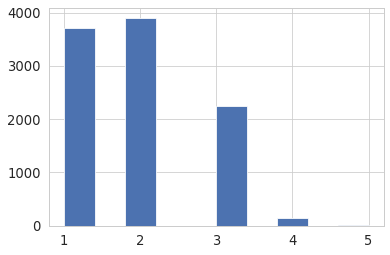

In [799]:
df_train.Rooms.hist()

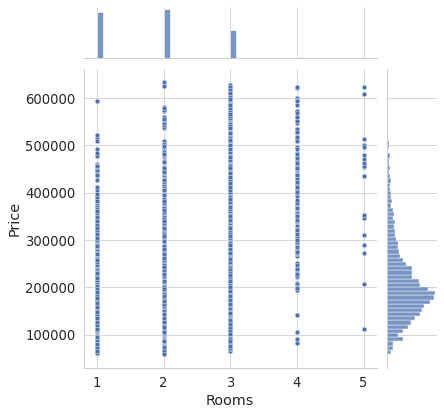

In [800]:
sns.jointplot(df_train['Rooms'], df_train['Price'], kind='scatter', height=6);

#### KitchenSquare


In [801]:
df_train.sort_values(by='KitchenSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
2971,1,1.00,42.85,40.92,0.00,9,17.00,1977,0.01,1,1,1,264,0,NaN,0,1,1,"136,740.78"
2488,23,2.00,51.77,48.26,0.00,3,9.00,2015,0.03,1,1,0,168,0,NaN,0,0,1,"103,450.23"
7821,27,2.00,59.75,NaN,0.00,8,12.00,1977,0.01,1,1,4,915,0,NaN,0,0,1,"137,243.73"
6993,23,2.00,62.16,60.96,0.00,7,25.00,1977,0.08,1,1,6,1437,3,NaN,0,2,1,"166,599.05"
322,1,2.00,64.43,64.31,0.00,10,20.00,1977,0.01,1,1,1,264,0,NaN,0,1,1,"207,032.14"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,62,3.00,114.73,112.59,112.00,3,3.00,2015,0.07,1,1,2,629,1,NaN,0,0,0,"315,245.52"
12552,58,3.00,116.41,113.11,112.00,3,3.00,2016,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"296,165.94"
2737,27,3.00,123.43,125.81,123.00,5,10.00,2015,0.02,1,1,2,469,0,NaN,0,0,1,"234,194.84"


Есть нулевые значения. Попробуем оставить, т.к., теоретически, есть коммунальные квартиры и студии, где кухни могут не выделяться в отдельную площадь

In [802]:
df_train.loc[df_train['KitchenSquare'] >= 150, 'KitchenSquare'] /= 100

In [803]:
df_train.sort_values(by='KitchenSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
2971,1,1.00,42.85,40.92,0.00,9,17.00,1977,0.01,1,1,1,264,0,NaN,0,1,1,"136,740.78"
2488,23,2.00,51.77,48.26,0.00,3,9.00,2015,0.03,1,1,0,168,0,NaN,0,0,1,"103,450.23"
7821,27,2.00,59.75,NaN,0.00,8,12.00,1977,0.01,1,1,4,915,0,NaN,0,0,1,"137,243.73"
6993,23,2.00,62.16,60.96,0.00,7,25.00,1977,0.08,1,1,6,1437,3,NaN,0,2,1,"166,599.05"
322,1,2.00,64.43,64.31,0.00,10,20.00,1977,0.01,1,1,1,264,0,NaN,0,1,1,"207,032.14"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,27,1.00,38.22,18.72,84.00,4,17.00,2018,0.01,1,1,4,915,0,NaN,0,0,1,"99,079.96"
12390,72,3.00,97.49,99.32,96.00,22,25.00,2019,0.21,1,1,11,2398,2,"1,994.00",3,0,1,"445,074.96"
12552,58,3.00,116.41,113.11,112.00,3,3.00,2016,0.44,1,1,23,5735,3,"1,084.00",0,5,1,"296,165.94"


#### LifeSquare

In [804]:
df_train[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare']].describe()

,Rooms,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","7,887.00","10,000.00"
mean,1.89,56.21,37.20,5.88
std,0.81,19.08,86.24,5.18
min,1.00,11.37,0.37,0.00
25%,1.00,41.78,22.77,1.00
50%,2.00,52.51,32.78,6.00
75%,2.00,65.89,45.13,9.00
max,5.00,275.65,"7,480.59",123.00


<AxesSubplot:>

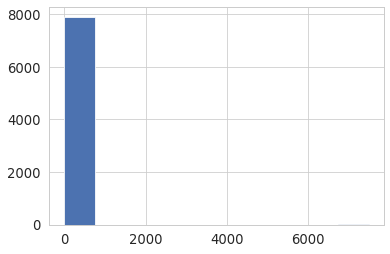

In [805]:
df_train.LifeSquare.hist()

In [806]:
df_train.sort_values(by='LifeSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
13491,0,1.00,38.18,0.37,0.00,19,17.00,2016,0.01,1,1,30,5285,0,645.00,6,6,1,"105,134.29"
4378,27,3.00,106.96,0.64,0.00,17,0.00,2018,0.07,1,1,2,629,1,NaN,0,0,0,"337,299.87"
5112,6,2.00,63.59,0.80,10.00,17,17.00,2014,0.24,1,1,5,1564,0,540.00,0,0,1,"174,742.00"
3224,27,1.00,23.77,0.87,0.00,1,0.00,1977,0.02,1,1,2,469,0,NaN,0,0,1,"126,596.94"
15402,27,2.00,58.52,1.05,1.00,4,17.00,2014,0.07,1,1,2,629,1,NaN,0,0,0,"142,393.08"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16159,27,1.00,38.97,NaN,1.00,10,1.00,1977,0.21,1,1,9,1892,0,NaN,0,1,1,"95,529.57"
2996,1,2.00,64.99,NaN,1.00,9,22.00,1977,0.01,1,1,1,264,0,NaN,0,1,1,"200,332.51"
15623,23,2.00,55.62,NaN,0.00,2,4.00,1977,0.03,1,1,0,168,0,NaN,0,0,1,"115,797.55"


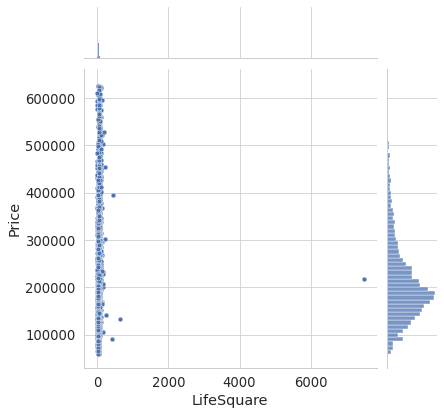

In [807]:
sns.jointplot(df_train['LifeSquare'], df_train['Price'], kind='scatter', height=6);

In [808]:
df_train.loc[df_train['LifeSquare'] < 0.86, 'LifeSquare'] *= 100
df_train.loc[((df_train['LifeSquare'] >= 0.86) & (df_train['LifeSquare'] <= 10)), 'LifeSquare'] *= 10
df_train.loc[((df_train['LifeSquare'] > 250) & (df_train['LifeSquare'] <= 500)), 'LifeSquare'] /= 10
df_train.loc[df_train['LifeSquare'] > 500, 'LifeSquare'] /= 100

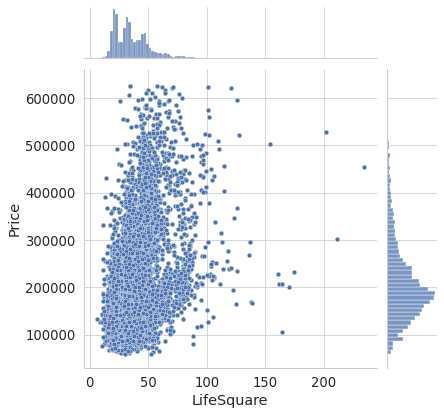

In [809]:
sns.jointplot(df_train['LifeSquare'], df_train['Price'], kind='scatter', height=6);

In [810]:
df_train.sort_values(by='LifeSquare')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11602,30,2.00,64.11,6.38,10.00,20,19.00,2019,0.00,1,1,22,6398,141,"1,046.00",3,23,1,"133,529.68"
3224,27,1.00,23.77,8.73,0.00,1,0.00,1977,0.02,1,1,2,469,0,NaN,0,0,1,"126,596.94"
15402,27,2.00,58.52,10.50,1.00,4,17.00,2014,0.07,1,1,2,629,1,NaN,0,0,0,"142,393.08"
7857,27,2.00,43.96,10.52,19.00,15,17.00,2006,0.08,1,1,11,3097,0,NaN,0,0,1,"143,688.08"
828,90,1.00,20.92,10.65,3.00,7,5.00,1968,0.27,1,1,37,5288,0,"1,937.00",3,2,1,"128,808.09"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16159,27,1.00,38.97,NaN,1.00,10,1.00,1977,0.21,1,1,9,1892,0,NaN,0,1,1,"95,529.57"
2996,1,2.00,64.99,NaN,1.00,9,22.00,1977,0.01,1,1,1,264,0,NaN,0,1,1,"200,332.51"
15623,23,2.00,55.62,NaN,0.00,2,4.00,1977,0.03,1,1,0,168,0,NaN,0,0,1,"115,797.55"


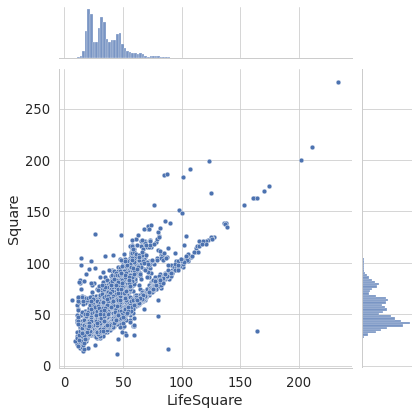

In [811]:
sns.jointplot(df_train['LifeSquare'], df_train['Square'], kind='scatter', height=6);

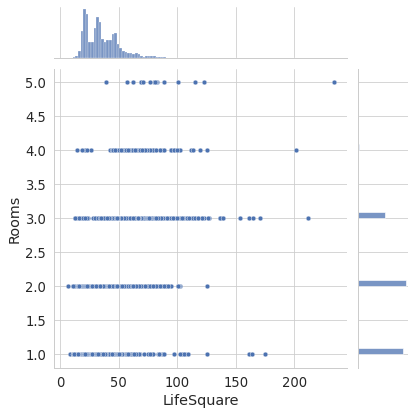

In [812]:
sns.jointplot(df_train['LifeSquare'], df_train['Rooms'], kind='scatter', height=6);

In [813]:
df_train = df_train.sort_values(by='Square')
df_train.LifeSquare.fillna(method='pad', inplace=True)

In [814]:
df_train[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare']].describe()

,Rooms,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.21,37.70,5.88
std,0.81,19.08,17.52,5.18
min,1.00,11.37,6.38,0.00
25%,1.00,41.78,23.69,1.00
50%,2.00,52.51,33.81,6.00
75%,2.00,65.89,46.05,9.00
max,5.00,275.65,233.95,123.00


#### Healthcare_1

В данном признаке почти 48% пропусков. Возможно его заполнение, например медианными значениями или удаление признака полностью. Удалить всегда успеем. Попробуем пропуски в Healthcare_1 заполнить методом ‘pad’(‘ffill’), отсортировав датасет по району.

In [815]:
 # Заготовка для удаления признака
 #  if 'Healthcare_1' in df_train.columns:
#          df_train.drop('Healthcare_1', axis=1, inplace=True)

In [816]:
df_train=df_train.sort_values(by='DistrictId')
df_train.Healthcare_1.fillna(method='pad',inplace=True)

#### HouseYear

In [817]:
df_train.sort_values(by='HouseYear')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
13288,161,1.00,50.81,15.92,20.00,8,9.00,1910,0.01,1,1,19,3806,4,"4,129.00",0,3,1,"287,954.72"
14556,183,4.00,151.15,98.19,23.00,6,7.00,1912,0.04,1,1,32,6748,93,562.00,4,10,1,"284,884.96"
2085,161,1.00,63.29,29.39,18.00,3,9.00,1912,0.01,1,1,19,3806,4,"4,129.00",0,3,1,"262,279.81"
6751,172,2.00,56.17,28.38,7.00,8,6.00,1914,0.00,1,1,7,1660,39,"1,786.00",1,5,1,"423,580.48"
7920,183,3.00,102.96,48.32,14.00,4,6.00,1916,0.04,1,1,32,6748,93,562.00,4,10,1,"284,608.94"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,62,1.00,49.30,51.14,9.00,9,12.00,2020,0.07,1,1,2,629,1,"2,300.00",0,0,0,"151,779.18"
12191,74,1.00,42.80,19.82,13.00,3,1.00,2020,0.08,1,1,6,1437,3,750.00,0,2,1,"162,260.68"
9303,53,2.00,57.13,40.27,10.00,11,24.00,2020,0.05,1,1,34,7759,0,229.00,1,3,1,"263,206.22"


В датасете только два ошибочных значения, исправим их вручную. Также оставим правило, что делать, если указан год больше текущего

In [818]:
df_train.loc[df_train['HouseYear'] == 4968, 'HouseYear'] = 1968
df_train.loc[df_train['HouseYear'] == 20052011, 'HouseYear'] = 2011

In [819]:
current_year = datetime.datetime.now().year
df_train.loc[df_train['HouseYear'] > current_year, 'HouseYear'] = current_year

#### Floor и HouseFloor


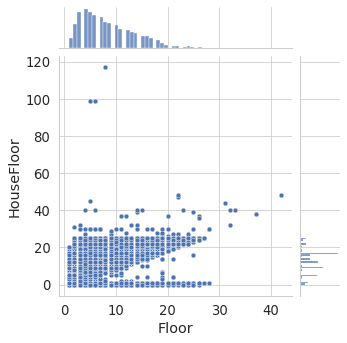

In [820]:
sns.jointplot(df_train['Floor'], df_train['HouseFloor'], kind='scatter', height=5)

In [821]:
df_train.sort_values(by='Floor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
4175,1,2.00,66.95,67.66,0.00,1,20.00,1977,0.01,1,1,1,264,0,200.00,0,1,1,"148,389.99"
12826,1,1.00,48.06,30.62,1.00,1,1.00,1977,0.01,1,1,1,264,0,200.00,0,1,1,"124,591.33"
16443,29,1.00,37.48,17.95,6.00,1,5.00,1960,0.09,1,1,10,2277,2,"1,547.00",0,0,1,"118,162.89"
13869,2,2.00,47.35,31.59,5.00,1,5.00,1965,0.00,1,1,33,7425,1,"2,620.00",2,5,1,"174,476.80"
6903,23,1.00,36.37,24.97,1.00,1,1.00,1977,0.03,1,1,0,168,0,0.00,0,0,1,"88,289.94"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,8,1.00,50.39,41.64,0.00,32,32.00,2008,0.09,1,1,21,4346,2,165.00,1,2,1,"97,480.85"
3298,31,1.00,57.55,21.55,10.00,32,40.00,1977,0.15,1,0,32,5889,10,830.00,4,1,1,"393,799.53"
8016,31,1.00,59.52,24.05,10.00,33,40.00,1977,0.15,1,0,32,5889,10,830.00,4,1,1,"389,554.06"


In [822]:
df_train.sort_values(by='HouseFloor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
214,27,1.00,47.93,30.26,0.00,11,0.00,1977,0.02,1,1,2,469,0,"2,672.00",0,0,1,"144,180.48"
9039,27,3.00,89.79,43.77,0.00,7,0.00,1977,0.07,1,1,2,629,1,"2,672.00",0,0,0,"259,654.50"
9371,23,2.00,60.50,35.59,0.00,16,0.00,1977,0.03,1,1,0,168,0,0.00,0,0,1,"229,778.06"
328,45,1.00,42.71,27.62,0.00,5,0.00,1977,0.20,1,1,23,5212,6,"1,308.00",3,2,1,"282,454.66"
16627,23,2.00,57.18,57.69,0.00,9,0.00,1977,0.03,1,1,0,168,0,0.00,0,0,1,"141,072.49"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,76,2.00,74.34,41.04,5.00,42,48.00,2016,0.00,1,1,7,1660,39,"1,786.00",1,5,1,"411,691.50"
7453,24,3.00,126.62,62.46,12.00,22,48.00,2011,0.11,1,1,50,12238,8,"1,970.00",2,3,1,"179,396.52"
10806,5,1.00,51.94,48.71,1.00,6,99.00,1977,0.15,1,1,16,3433,4,"2,643.00",4,5,1,"296,127.12"


In [823]:
len(df_train[(df_train['Floor'] > df_train['HouseFloor'])])

1825

Вызывают сомнения следующие моменты:
- В части строк значение HouseFloor = 0
- В 1825 случаях HouseFloor < Floor
- Есть дома с этажностью 99 и 117, что маловероятно

In [824]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'Floor'] = df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'HouseFloor']
df_train.loc[df_train['HouseFloor'] > 98, 'HouseFloor'] = df_train['HouseFloor'].median()

In [825]:
df_train.sort_values(by='Floor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
3815,9,1.00,42.75,22.93,1.00,1.00,1.00,1977,0.16,1,1,25,5648,1,30.00,2,4,1,"139,025.79"
14197,62,2.00,63.80,61.68,10.00,1.00,1.00,1977,0.07,1,1,2,629,1,"2,300.00",0,0,0,"198,577.23"
13144,62,1.00,47.11,27.05,1.00,1.00,1.00,1977,0.07,1,1,2,629,1,"2,300.00",0,0,0,"156,512.03"
7346,62,1.00,34.77,18.48,9.00,1.00,17.00,1991,0.39,1,1,5,1135,0,"2,300.00",0,0,0,"87,553.99"
4319,62,1.00,51.82,42.03,1.00,1.00,1.00,1977,0.07,1,1,2,629,1,"2,300.00",0,0,0,"137,880.62"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,8,1.00,50.39,41.64,0.00,32.00,32.00,2008,0.09,1,1,21,4346,2,165.00,1,2,1,"97,480.85"
3298,31,1.00,57.55,21.55,10.00,32.00,40.00,1977,0.15,1,0,32,5889,10,830.00,4,1,1,"393,799.53"
8016,31,1.00,59.52,24.05,10.00,33.00,40.00,1977,0.15,1,0,32,5889,10,830.00,4,1,1,"389,554.06"


In [826]:
df_train.sort_values(by='HouseFloor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
8849,45,1.00,63.42,22.86,1.00,1.00,1.00,1977,0.20,1,1,23,5212,6,"1,308.00",3,2,1,"325,600.77"
15667,37,2.00,69.47,65.98,1.00,1.00,1.00,1977,0.18,1,1,18,3594,4,192.00,1,5,1,"333,225.12"
14619,34,3.00,94.05,52.57,1.00,1.00,1.00,1977,0.07,1,1,53,13670,4,800.00,1,11,1,"354,075.96"
335,34,3.00,81.65,45.24,1.00,1.00,1.00,1977,0.07,1,1,53,13670,4,800.00,1,11,1,"314,648.96"
2913,34,4.00,94.89,26.37,1.00,1.00,1.00,2018,0.07,1,1,53,13670,4,800.00,1,11,1,"346,949.51"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,30,1.00,62.11,52.81,4.00,31.00,44.00,2009,0.00,1,1,22,6398,141,"1,046.00",3,23,1,"117,647.46"
5279,93,2.00,60.80,30.92,11.00,5.00,45.00,2016,0.05,1,1,43,10621,1,30.00,2,3,1,"213,171.14"
6502,20,1.00,126.39,103.64,14.00,22.00,47.00,2012,0.02,1,1,37,7687,11,176.00,5,5,1,"450,706.55"


### Обработка редких категорий

In [827]:
#print('Уникальные значения в train:', df_train['DistrictId'].nunique())

In [828]:
#district_size = df_train['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId': 'DistrictSize'})
#district_size.head()

In [829]:
#sns.set(style="whitegrid", font_scale=1.5)
#f, ax = plt.subplots(figsize=(16, 6))
#sns.barplot(y='DistrictSize', x='DistrictId',
#            data=district_size,
#            order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']
#            );
#ax.tick_params(axis='x', rotation=90)
#ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [830]:
#district_size.loc[district_size['DistrictSize'] >= 50, :]

In [831]:
#districts_popular = district_size.loc[district_size['DistrictSize'] >= 50, 'DistrictId'].tolist()

In [832]:
#district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
#district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(DistrictSize='median')
#district_size.reset_index(level='DistrictId', inplace=True)
#district_size

In [833]:
#df_train.loc[~df_train['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
#df_train['DistrictId'].value_counts()

### Генерация новых признаков

DistrictSize - Frequency Encoding

In [834]:
#df_train = df_train.merge(district_size, on='DistrictId', how='left').set_index(df_train.index)
#df_train.head()

Price_m2 - Цена квадратоного метра

In [835]:
df_train['Price_m2'] = df_train['Price'] / df_train['Square']

Price_m2_by_district - Цена квадратоного метра по району

In [836]:
price_m2_by_district = df_train.groupby(['DistrictId'], as_index=False).agg({'Price_m2':'median'}).rename(columns={'Price_m2':'Price_m2_by_district'})
price_m2_by_district

,DistrictId,Price_m2_by_district
0,0,"3,935.91"
1,1,"3,251.65"
2,2,"4,550.71"
3,3,"3,892.20"
4,4,"5,716.89"
...,...,...
200,202,"7,447.53"
201,205,"5,101.02"
202,207,"5,550.68"
203,208,"8,005.61"


In [837]:
df_train = df_train.merge(price_m2_by_district, on=['DistrictId'], how='left').set_index(df_train.index)

In [838]:
df_train = df_train.drop('Price_m2', axis=1)

Price_One_Room

In [839]:
df_train['Price_One_Room'] = df_train['Price'] / df_train['Rooms']

In [840]:
#df_train['Price_One_Room'].describe()

Price_Room_by_district - Likelihood Encoding

In [841]:
price_room_by_district = df_train.groupby(['DistrictId'], as_index=False).agg({'Price_One_Room': 'median'}).rename(columns={'Price_One_Room': 'Price_Room_by_district'})
price_room_by_district

,DistrictId,Price_Room_by_district
0,0,"108,490.12"
1,1,"106,080.90"
2,2,"125,268.53"
3,3,"103,437.97"
4,4,"146,358.97"
...,...,...
200,202,"173,224.11"
201,205,"220,501.57"
202,207,"142,062.14"
203,208,"215,568.83"


In [842]:
df_train = df_train.merge(price_room_by_district, on=['DistrictId'], how='left').set_index(df_train.index)

In [843]:
df_train = df_train.drop('Price_One_Room', axis=1)

In [844]:
#df_train.head()

RoomSquare

In [845]:
df_train['RoomSquare'] = df_train['Square'] / df_train['Rooms']

In [846]:
#df_train.head()

Price_LifeSquare_By_District

In [847]:
df_train['Price_LifeSquare'] = df_train['Price'] / df_train['LifeSquare']

In [848]:
#df_train['Price_LifeSquare'].describe()

In [849]:
price_LifeSquare_by_district = df_train.groupby(['DistrictId'], as_index=False).agg({'Price_LifeSquare': 'median'}).rename(columns={'Price_LifeSquare': 'Price_LifeSquare_by_district'})
price_LifeSquare_by_district

,DistrictId,Price_LifeSquare_by_district
0,0,"6,182.84"
1,1,"4,518.85"
2,2,"7,475.65"
3,3,"6,288.50"
4,4,"8,410.15"
...,...,...
200,202,"10,625.06"
201,205,"11,814.56"
202,207,"7,641.85"
203,208,"12,913.67"


In [850]:
df_train = df_train.merge(price_LifeSquare_by_district, on=['DistrictId'], how='left').set_index(df_train.index)

In [851]:
df_train = df_train.drop('Price_LifeSquare', axis=1)

In [852]:
#df_train.head()

Price_KitchenSquare_By_District

In [853]:
df_train['Price_KitchenSquare'] = df_train['Price'] / df_train['KitchenSquare']

In [854]:
#df_train['Price_KitchenSquare'].describe()

In [855]:
price_KitchenSquare_by_district = df_train.groupby(['DistrictId'], as_index=False).agg({'Price_KitchenSquare': 'median'}).rename(columns={'Price_KitchenSquare': 'Price_KitchenSquare_by_district'})
price_KitchenSquare_by_district

,DistrictId,Price_KitchenSquare_by_district
0,0,"28,979.52"
1,1,"179,465.76"
2,2,"33,693.29"
3,3,"24,908.04"
4,4,"47,720.96"
...,...,...
200,202,"57,741.37"
201,205,"27,562.70"
202,207,"60,883.77"
203,208,"57,721.93"


In [856]:
df_train = df_train.merge(price_KitchenSquare_by_district, on=['DistrictId'], how='left').set_index(df_train.index)

In [857]:
df_train = df_train.drop('Price_KitchenSquare', axis=1)

In [858]:
#df_train.head()

Price_Floor_By_District

In [859]:
df_train['Price_Floor'] = df_train['Price'] / df_train['Floor']
#df_train['Price_Floor'].describe()
price_Floor_by_district = df_train.groupby(['DistrictId'], as_index=False).agg({'Price_Floor': 'median'}).rename(columns={'Price_Floor': 'Price_Floor_by_district'})
#price_Floor_by_district
df_train = df_train.merge(price_Floor_by_district, on=['DistrictId'], how='left').set_index(df_train.index)
df_train = df_train.drop('Price_Floor', axis=1)
#df_train.head()

Price_HouseFloor_by_district

In [860]:
df_train['Price_HouseFloor'] = df_train['Price'] / df_train['HouseFloor']
#df_train['Price_HouseFloor'].describe()
price_HouseFloor_by_district = df_train.groupby(['DistrictId'], as_index=False).agg({'Price_HouseFloor': 'median'}).rename(columns={'Price_HouseFloor': 'Price_HouseFloor_by_district'})
#price_HouseFloor_by_district
df_train = df_train.merge(price_HouseFloor_by_district, on=['DistrictId'], how='left').set_index(df_train.index)
df_train = df_train.drop('Price_HouseFloor', axis=1)
#df_train.head()

Price_HouseYear_By_District

In [861]:
df_train['Price_HouseYear'] = df_train['Price'] / df_train['HouseYear']
#df_train['Price_HouseYear'].describe()
price_HouseYear_by_district = df_train.groupby(['DistrictId'], as_index=False).agg({'Price_HouseYear': 'median'}).rename(columns={'Price_HouseYear': 'Price_HouseYear_by_district'})
#price_HouseYear_by_district
df_train = df_train.merge(price_HouseYear_by_district, on=['DistrictId'], how='left').set_index(df_train.index)
df_train = df_train.drop('Price_HouseYear', axis=1)
#df_train.head()

In [862]:
#poly = PolynomialFeatures(2)

In [863]:
#poly.fit_transform(df_train)

### 4. Построение моделей

#### 4.1 Отбор признаков

In [864]:
target_name = ['Price']
feature_names = [
    'DistrictId',
    'Rooms',
    'Square',
    'LifeSquare',
    'KitchenSquare',
    'Floor',
    'HouseFloor',
    'HouseYear',
    'Ecology_1',
    'Ecology_2',
    'Ecology_3',
    'Social_1',
    'Social_2',
    'Social_3',
    'Healthcare_1',
    'Helthcare_2',
    'Shops_1',
    'Shops_2',
    'Price',
#    'DistrictSize',
    'Price_m2_by_district',
    'Price_Room_by_district',
    'Price_LifeSquare_by_district',
#    'Price_KitchenSquare_by_district',
    'Price_Floor_by_district',
    'Price_HouseFloor_by_district',
    'Price_HouseYear_by_district'
]


In [865]:
feature_names_full = [feature for feature in feature_names if feature not in ['Price']]
len(feature_names_full)

24

In [866]:
X = df_train[feature_names_full]
y = df_train[target_name]

### Нормализация

In [867]:
#scaler = RobustScaler()
#scaled_features = X.copy()
#colnames = []
#features = scaled_features[colnames]
#scaler = RobustScaler().fit(features.values)
#features = scaler.transform(features.values)
#scaled_features[colnames] = features
#print(scaled_features)

In [868]:
#scaler = RobustScaler()

#colnames = X.columns
#X_train_scaled = pd.DataFrame(scaler.fit_transform(X), columns=colnames)

#X_train_scaled.head(2)


In [869]:
#X_train_scaled.describe()

### Понижение размерности

PCA - Principal Component Analysis (метод главных компонент)

### Построение модели Random Forest

In [870]:
forest = RandomForestRegressor(random_state=42)
kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))
# R2: 0.73085 - все 21 (с объединением районов)
# R2: 0.74017 - 20 фич (без объединения районов)

R2: 0.74307


Важность признаков

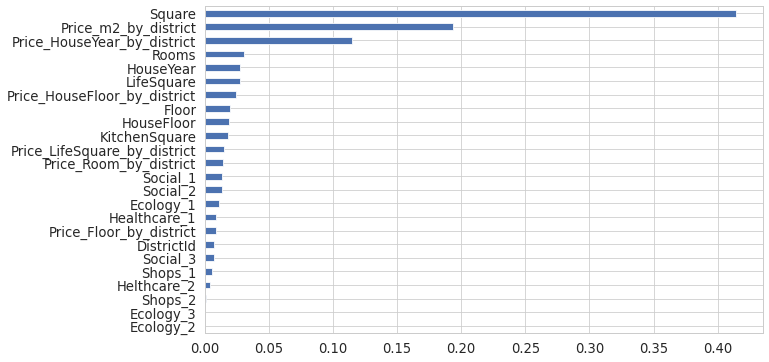

In [871]:
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names_full)
feat_importances.sort_values(ascending=True, inplace=True)
feat_importances.plot(kind='barh', figsize=(10, 6));

Отбор признаков методом RFE

In [872]:
X_full = df_train[feature_names_full]
len(feature_names_full)

24

In [873]:
rfe = RFE(estimator=forest,
          n_features_to_select=15,
          step=2)

rfe.fit(X_full, y)
X_full.columns[rfe.support_]

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Price_m2_by_district', 'Price_Room_by_district',
       'Price_LifeSquare_by_district', 'Price_HouseFloor_by_district',
       'Price_HouseYear_by_district'],
      dtype='object')

In [874]:
X_new = rfe.transform(X_full)
scores = cross_val_score(forest, X_new, y, scoring='r2', cv=kf)
print('R2: %.5f' % scores.mean())
# R2: 0.74062 - 20 фич (без объединения районов)

R2: 0.74462


In [875]:
# не запускать без надобности (очень долго)
##for n in range(10, 18, 1):
##   rfe = RFE(forest, n_features_to_select=n, step=2)
##  X_new = rfe.fit_transform(X_full, y)
##    scores = cross_val_score(forest, X_new, y, scoring='r2', cv=kf)
##    print('n_features_to_select: {} - R2: {:.5}'.format(n, scores.mean()))

### Настройка гиперпараметров модели

In [886]:
params = {
    #'n_estimators': [100],
    'max_depth': [14, 15, 16],
    'max_features': [4, 5, 6]
}

In [887]:
forest_grid = GridSearchCV(forest, params, scoring='r2',
                           cv=KFold(n_splits=5, random_state=42, shuffle=True),
                           n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_))

{'max_depth': 15, 'max_features': 5}
R2 на train: 0.75247


{'max_depth': 17, 'max_features': 5} - R2 на train: 0.74006 - все 21 фича (с объединением районов)
{'max_depth': 16, 'max_features': 6} - R2 на train: 0.75185 - все 20 фич (без объединения районов)
{'max_depth': 15, 'max_features': 5} - R2 на train: 0.75247 - все 24 фичи (доп признаки по цене)

### Gradient Boosting - Градиентный бустинг¶

In [878]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X, y)

GradientBoostingRegressor(random_state=42)

In [879]:
y_train_preds = gb_model.predict(X)

In [880]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [888]:
params = {'n_estimators':[75, 100, 150],
          'max_depth':[5, 6, 7]}

gs = GridSearchCV(gb_model, params, scoring='r2',
                  cv=kf, n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7],
                         'n_estimators': [75, 100, 150]},
             scoring='r2')

In [889]:
gs.best_params_

{'max_depth': 6, 'n_estimators': 100}

In [890]:
gs.best_score_

0.7544959123415113

{'max_depth': 6, 'n_estimators': 100} - 0.7392369427513443
{'max_depth': 6, 'n_estimators': 75} - 0.7479173727202253 (без объединения районов)
{'max_depth': 6, 'n_estimators': 100} - 0.7544959123415113 (с доп признаками по цене)

### LGBMRegressor

In [914]:
lgbm_regressor_model = LGBMRegressor(max_depth=4,
                                     n_estimators=200,
                                     random_state=42)
lgbm_regressor_model.fit(X, y)

cv_score = cross_val_score(lgbm_regressor_model, X, y,
                           scoring='r2',
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
mean = cv_score.mean()
std = cv_score.std()

print()
print('Base result:')
print('R2: {:.5f} +- {:.5f}'.format(mean, std))
print()


Base result:
R2: 0.75589 +- 0.02196



### Прогнозирование на тестовом датасете

In [915]:
final_model = LGBMRegressor(max_depth=4,
                            n_estimators=200,
                            random_state=42)
final_model.fit(X, y)
y_pred = final_model.predict(df_test[feature_names])
y_pred

KeyError: "['Price', 'Price_m2_by_district', 'Price_Room_by_district', 'Price_LifeSquare_by_district', 'Price_Floor_by_district', 'Price_HouseFloor_by_district', 'Price_HouseYear_by_district'] not in index"

In [916]:
preds = pd.DataFrame()
preds['Id'] = df_test.index
preds['Price'] = y_pred
preds.head()

NameError: name 'y_pred' is not defined